# Notebook Adam

# Introduction


### import libraries

In [8]:
import os
import pickle
import utilities_Copy1
from random import sample
from multiprocessing import cpu_count
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from ipywidgets import interact
import seaborn as sns
# import pyLDAvis
# import pyLDAvis.gensim


from typing import List
from collections import defaultdict
from collections import Counter

import re
import nltk
import umap
import hdbscan
from sklearn.cluster import KMeans
from itertools import chain

from umap import UMAP
from hdbscan import HDBSCAN

from bertopic import BERTopic
# from top2vec import Top2Vec
# from gensim.models.word2vec import Word2Vec
# from transformers import BertTokenizer, BertModel
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer
from gensim.models import LdaMulticore
from wordcloud import WordCloud
from gensim.models import CoherenceModel


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from nltk.stem import WordNetLemmatizer

import gensim.downloader as api
from gensim import corpora, models

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
import nltk.corpus

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise_distances_argmin_min

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.tekiouk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from r_metrics import compute_coherence
from r_metrics import compute_topic_diversity
from r_metrics import compute_similarity_intra_cluster
from r_metrics import compute_cosine_similarity_words
from r_metrics import plot_metrics
from r_metrics import plot_diversities
from r_metrics import circle_packing_density
from r_metrics import weighted_average

from r_visualization import visualize_documents_universal
from r_visualization import visualize_barchart_top2vec
from r_visualization import create_wordcloud
from r_visualization import compute_centroid_radius
from r_visualization import plot_centroid_radius_frequency
from r_visualization import plot_interactive_frequence_top15words
from r_visualization import plt_cluster_frequency
from r_visualization import get_tfidf_top10words_normalized
from r_visualization import plot_tfidf_values
# from r_visualization import plot_interactive_frequence_top10words_normalized

from r_utils import format_name
from r_utils import get_words_list_top2vec
from r_utils import get_words_list_bertopic
from r_utils import get_words_list_lda
from r_utils import get_df_top10words_BERTopic
from r_utils import get_df_top10words_top2vec
from r_utils import preprocess_text
from r_utils import lemmatize_words
from r_utils import remove_stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.tekiouk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.tekiouk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset

In [3]:
corpus_filtered = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/DATA/corpus_filtered.csv")
corpus_filtered = corpus_filtered.dropna(axis='rows')

In [10]:
corpus_chan_10k = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/DATA/chanel10k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus_chan_10k["language"] == 'en'
corpus_chan_10k = corpus_chan_10k.loc[mask]
corpus_base = corpus_chan_10k.dropna(axis='rows')
import textdistance
dist = textdistance.levenshtein.normalized_distance
corpus_base = utilities_Copy1.delete_duplicates(corpus_base['text'].tolist(),corpus_base['publication_time'].tolist(),0.5,dist)

In [12]:
pd.DataFrame(corpus_base).to_csv("C:/Users/a.tekiouk/Sujet_2/DATA/chanel_base_dd.csv")

In [19]:
corpus_base = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/DATA/chanel_base_dd.csv")
corpus_base['text'] = corpus_base['0']
corpus_base = corpus_base.dropna(axis='rows')

In [17]:
corpus_base = corpus_base.dropna(axis='rows')

,Unnamed: 0,0,text
0,0,her barbie era has officially begun - margot r...,her barbie era has officially begun - margot r...
1,1,If you like big shoulders you’ve come to the r...,If you like big shoulders you’ve come to the r...
2,2,No captions 💋\n\n.\n.\n.\n.\n.,No captions 💋\n\n.\n.\n.\n.\n.
3,3,Chance Eau Tendre EdP - Chanel\nWhich Chanel i...,Chance Eau Tendre EdP - Chanel\nWhich Chanel i...
4,4,So grow up. Stop fucking other women. Just fuc...,So grow up. Stop fucking other women. Just fuc...
...,...,...,...
911,911,Chanel necklace\n \n\nChanel 蝴蝶結 項鍊 約99新✨\n...,Chanel necklace\n \n\nChanel 蝴蝶結 項鍊 約99新✨\n...
912,912,⭐️Champagne o’clock 🍾 több információért gyert...,⭐️Champagne o’clock 🍾 több információért gyert...
913,913,🤎\n\nitaliano_woman_wear1 \nitaliano_woman_wea...,🤎\n\nitaliano_woman_wear1 \nitaliano_woman_wea...
914,914,When you’ve peeves over this bag for so long. ...,When you’ve peeves over this bag for so long. ...


# Bertopic

In [22]:
stop_words = stopwords.words('english')

ENCODER_ID = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(ENCODER_ID)

vectorizer = CountVectorizer(stop_words=stop_words)
                                             
umap = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan = HDBSCAN(min_cluster_size=35, min_samples=1, metric='euclidean', cluster_selection_method='eom')

bert_topic_model = BERTopic(
    embedding_model=encoder,
    umap_model=umap, 
    hdbscan_model=hdbscan,
    vectorizer_model=vectorizer,
    verbose=True
    )

docs = corpus_base['text'].tolist()

embeddings = encoder.encode(docs)

docs = corpus_base['text'].tolist()
bert_topic_model.fit(docs, embeddings)
print(f"Total topics found by BERTopic: {len(bert_topic_model.topic_labels_.keys())} (the topic -1 represents the outliers)")

2023-08-24 16:08:05,551 - BERTopic - Reduced dimensionality
2023-08-24 16:08:05,569 - BERTopic - Clustered reduced embeddings


Total topics found by BERTopic: 12 (the topic -1 represents the outliers)


In [6]:
# reduce topics
# bert_topic_model.reduce_topics(docs, nr_topics=TOPIC_COUNT + 1)  # extra topic is for outliers

**Create dataframe with id_topic and top 10 words for each topic**

In [23]:
bert_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,167,-1_new_gold_commercial_timothée,"[new, gold, commercial, timothée, size, chanel...",[Timothée Chalamet and Havan Rose Liu for the ...
1,0,130,0_wedding_sofia_dress_chanelofficial,"[wedding, sofia, dress, chanelofficial, richie...",[They’re here! The first snaps of sofiarichie ...
2,1,120,1_happy_day_aesthetic_love,"[happy, day, aesthetic, love, like, black, tag...","[A beautiful and happy day, Loving my new eleg..."
3,2,81,2_chanel_beauty_coco_lagerfeld,"[chanel, beauty, coco, lagerfeld, one, cream, ...",[There’s a real beauty in balance. \n\nGrowing...
4,3,70,3_trendyfashioncave_𝔂𝓸𝓾_𝓲𝓼_𝓽𝓱𝓮,"[trendyfashioncave, 𝔂𝓸𝓾, 𝓲𝓼, 𝓽𝓱𝓮, 𝐲𝐨𝐮, ꜰᴏʟʟᴏᴡ,...","[𝐒𝐰𝐢𝐩𝐞 𝐟𝐨𝐫 𝐦𝐨𝐫𝐞 𝐩𝐢𝐜𝐭𝐮𝐫𝐞𝐬,𝐈𝐟 𝐲𝐨𝐮 𝐡𝐚𝐯𝐞 𝐚𝐧𝐲 𝐦𝐨𝐫𝐞 ..."
5,4,60,4_샤넬_italiano_woman_wear1_moisture_写真好きな人と繋がりたい,"[샤넬, italiano_woman_wear1, moisture, 写真好きな人と繋が...",[Goodnight 😴\n.\n.\n.\n#写真好きな人と繋がりたい \n#いいね返し ...
6,5,53,5_quality_contact_please_wholesale,"[quality, contact, please, wholesale, whatsapp...",[We are mainly engaged in various brands of sh...
7,6,50,6_de_en_la_por,"[de, en, la, por, un, ès, et, estilo, se, le]",[Timothee Chalamet y Martin Scorsese fueron vi...
8,7,50,7_chanel_com_condition_price,"[chanel, com, condition, price, new, item, ava...",[🩳Shorts =150/-rs 💰\nSIZE = FREE SIZE \n\n➡️Fo...
9,8,46,8_denim_spring_summer_wear,"[denim, spring, summer, wear, love, wearing, b...",[Make up a set of previous daily routine. Go t...


In [37]:
TOPIC_COUNT = 11
df_bertopic = get_df_top10words_BERTopic(bert_topic_model, nr_topics=TOPIC_COUNT+1)
df_bertopic.head(1)
df_bertopic

,id_topic,top_10_words
0,0,wedding sofia dress chanelofficial richie sofi...
1,1,happy day aesthetic love like black tags look ...
2,2,chanel beauty coco lagerfeld one cream fashion...
3,3,trendyfashioncave 𝔂𝓸𝓾 𝓲𝓼 𝓽𝓱𝓮 𝐲𝐨𝐮 ꜰᴏʟʟᴏᴡ 𝓽𝓸 mup...
4,4,샤넬 italiano_woman_wear1 moisture 写真好きな人と繋がりたい ...
5,5,quality contact please wholesale whatsapp clot...
6,6,de en la por un ès et estilo se le
7,7,chanel com condition price new item available ...
8,8,denim spring summer wear love wearing blazer p...
9,9,bag brands dm brand leather affiliated shoulde...


In [6]:
df_bertopic.shape

## Create dataframe

In [41]:
df_topics = pd.DataFrame({"tweets": docs, "bert_topic": bert_topic_model.topics_, "frequence": np.ones(len(bert_topic_model.topics_))})
df_topics.head(1)

,tweets,bert_topic,frequence
0,her barbie era has officially begun - margot r...,-1,1.0


# Evaluation

## Qualitatives metrics

1) **Visualize documents**

2) **Visualize intertopic distance map** (not useful)

3) **Visualize centroids and radius**

4) **Visualize barchart words**

5) **Frequency**

6) **Word cloud**

7) **Topic over time (only for BERTopic)**

### 1) Visualize documents

In [42]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [90]:
visualize_documents_universal(
    docs, 
    reduced_embeddings=reduced_embeddings,
    custom_labels=True,
    topic_per_doc = df_topics.bert_topic,
    names = format_name(df_bertopic)
)

### 2) Frequence

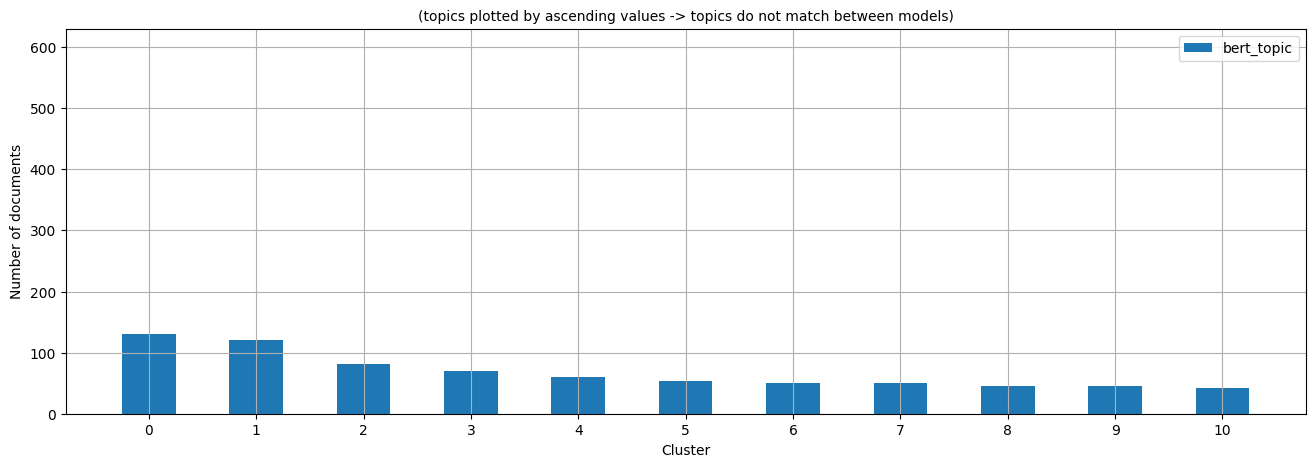

In [43]:
bertopic_topic_frequence = df_topics.groupby(by=["bert_topic"])["frequence"].sum()

df_bertopic["frequence"] = df_topics.groupby(by=["bert_topic"])["frequence"].sum()

frequencies = [bertopic_topic_frequence[1:]]
model_names = ["bert_topic"]

plt_cluster_frequency(frequencies, model_names)

### 3) Visualize centroids and radius

In [44]:
# compute frequency
bertopic_topic_frequence = df_topics.groupby(by=["bert_topic"])["frequence"].sum()


# compute centroid bertopic
labels = df_topics.bert_topic
df_bert_centroid = compute_centroid_radius(reduced_embeddings, labels)
df_bert_centroid["frequence"] = bertopic_topic_frequence
#df_bert_centroid.drop(-1,inplace=True)

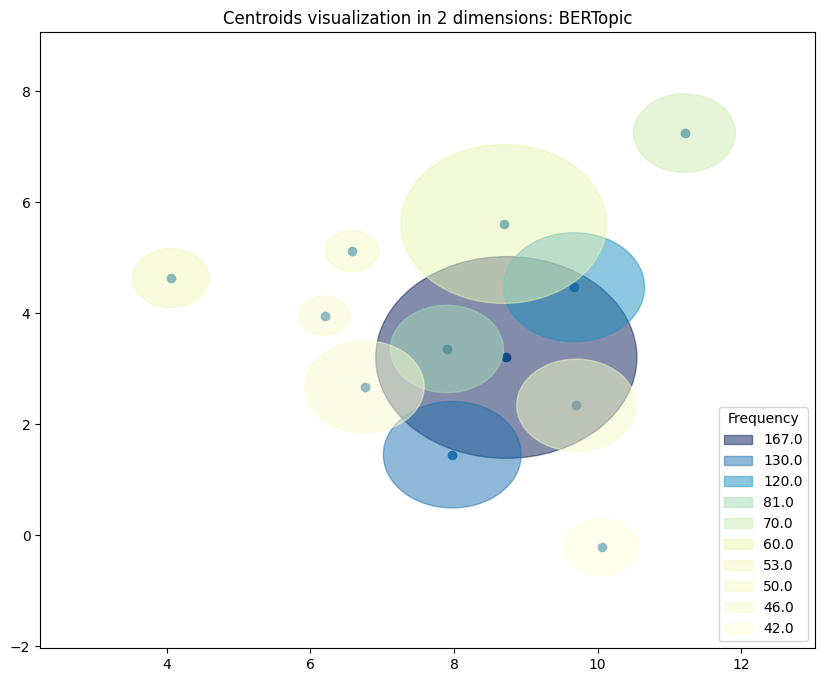

In [45]:
# # plot
plot_centroid_radius_frequency(df_bert_centroid, "Centroids visualization in 2 dimensions: BERTopic")

In [30]:
circle_packing_density(df_bert_centroid)

Total overlap area: 0.46 / total_circles_area : 12.55


0.036538124473098656

### 4) Visualize barchart words

In [62]:
bert_topic_model.visualize_barchart(n_words=9, top_n_topics=11)

### 4.1 Visualize barchart modify 

In this visualization, we will be calculating the **TF-IDF score** for each of the **top 10 words in each topic**. This analysis will help us **understand the frequency of these words in the cluster compared to the total frequency of these words across all documents in the collection**, taking into consideration the number of documents.

Typically, we use the term frequency to reflect how important a word is to a document in a collection or corpus. However, in this case, we will be using it to assess how important each word is to a cluster of documents within a collection. The TF-IDF score takes into account both the frequency of a term within a cluster and its rarity in the overall collection of documents, giving us a more nuanced understanding of the importance of each word to the cluster.

Our formula for computing the TF-IDF score involves two main components: term frequency (TF) and inverse document frequency (IDF).
To compute the **term frequency**, we first count the **number of documents in the subset that contain a given word j, and then divide this by the total number of documents in the subset k**. This gives us a measure of how frequently the word appears in the subset of documents we're interested in.
The IDF component takes into account the overall frequency of the word j in the entire corpus of documents. To compute **IDF, we divide the total number of documents in the corpus by the number of documents containing the word j, and then take the logarithm of this value to normalize it.**

$\;\;\;\;\;\;\;\;$ 

$$
\large
\frac{\text{number of documents containing "word" in subset } k}{\text{total number of documents in subset } k} * log( \frac{\text{total number of documents in the corpus}}{\text{number of documents containing "word" in the entire corpus}})
$$

$\;\;\;\;\;\;\;\;$ 



In [96]:
tf_idf, number_topics = get_tfidf_top10words_normalized(docs,df_topics.bert_topic,df_bertopic, bert_flag=True)
plot_tfidf_values(tf_idf, number_topics) 

### 5) WordCloud

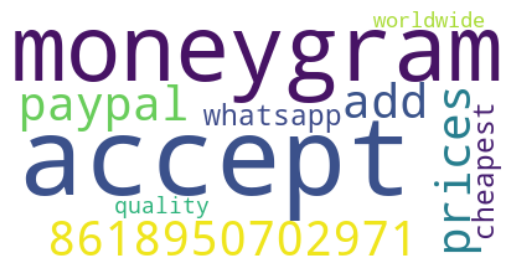

In [63]:
create_wordcloud(bert_topic_model, 1)

### 6) Topics over time
This visualization is exclusively available for BERTopic, and it enables us to observe the number of tweets generated for each topic over time. The time frame is determined by the "tweetAt" field, which is available when we download the data from the API. This visualization is intriguing as it enables us to identify which topics were generated during a specific time period.

In [67]:
timestamps = df_docs.timestamp.tolist()
topics_over_time = bert_topic_model.topics_over_time(docs, timestamps)
bert_topic_model.visualize_topics_over_time(topics_over_time, topics=[0,1,2,3,4,5,6,7])

NameError: name 'df_docs' is not defined

### Metrics quantitatives

1) **PMI score**

2) **topic diversity**

3) **embeddings cosine similarity**.

4) **Inertia**: cosine similarity between documents embeddings

In [32]:
words_list_bertopic = get_words_list_bertopic(bert_topic_model)
len(words_list_bertopic)

11

#### 1) PMI score

PMI score, or **pointwise mutual information**, quantifies the strength of the **association between pairs of words within a cluster**, ensuring that the chosen words are relevant to each other and coherent in conveying the topic.

In [46]:
coherence_bert_v = compute_coherence(docs, words_list_bertopic, metric = 'c_v', window_size = 25)

In [47]:
df_bertopic["c_v"] = coherence_bert_v

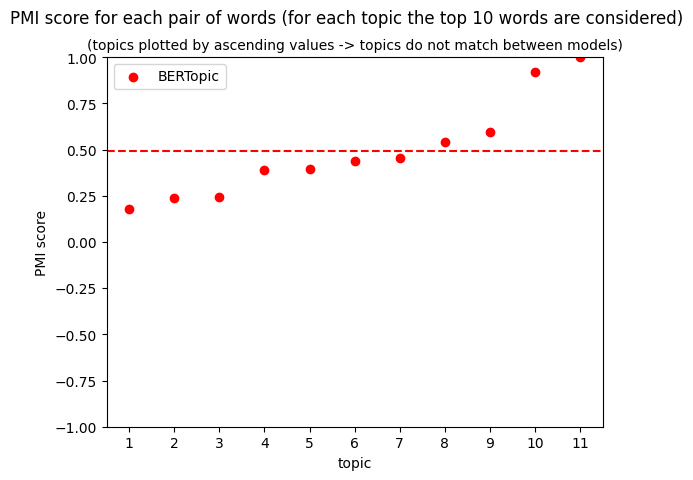

In [48]:
list1 = df_bertopic.c_v.sort_values(ascending=True)

lists_of_cv = [list1]
model_names = ["BERTopic"]

title = "PMI score for each pair of words (for each topic the top 10 words are considered)"
y_label = "PMI score"
plot_metrics(lists_of_cv, model_names, title, y_label, (-1,1))

In [49]:
weighted_average(coherence_bert_v, df_bertopic.frequence)

0.4966429562148003

#### 2) Topic diversity

In [127]:
topic_div_bert = compute_topic_diversity(words_list_bertopic)

In [128]:
df_bertopic["topic_div"] = topic_div_bert

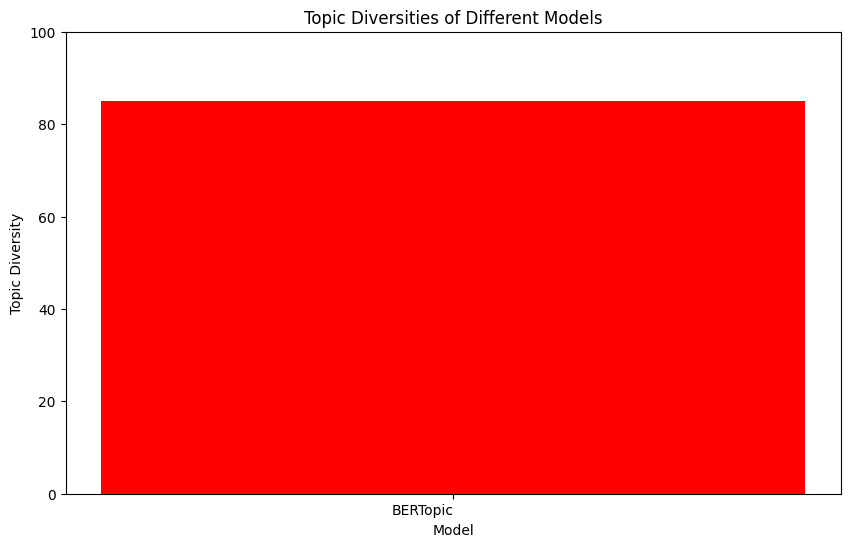

In [129]:
diversities = [topic_div_bert]
model_names = ["BERTopic"]
plot_diversities(diversities, model_names)

#### 3) Cosine similarity between the embeddings of the top 10 words (of each topic)
Embeddings cosine similarity measures the similarity between the vector representations of the words, ensuring that the words are semantically related and accurately capture the essence of the topic.

In [130]:
coherence_bert_emb = compute_cosine_similarity_words(words_list_bertopic)

FileNotFoundError: [Errno 2] No such file or directory: 'GoogleNews-vectors-negative300.bin.gz'

In [ ]:
df_bertopic["cos_sim_emb"] = coherence_bert_emb

In [ ]:
weighted_average(coherence_bert_emb, df_bertopic.frequence)

In [ ]:
list1 = df_bertopic.cos_sim_emb.sort_values(ascending=True)

lists_of_cv = [list1]
model_names = ["BERTopic"]

title = "Cosine similarity accross the top 10 words for each topic (embeddings calculated with all-MiniLM-L6-v2)"
y_label = "cosine similarity"
plot_metrics(lists_of_cv, model_names, title, y_label)

**Comment**

In this particular case, **Top2Vec obtained a higher score than BERTopic** for all the topics, while BERTopic's performance was similar to that of LDA. This outcome can be **attributed to the different approaches that these algorithms use to select the words that represent each topic**. 

Specifically, **Top2Vec chooses the words based on their cosine similarity to the cluster centroid, resulting in higher cosine similarity values between the selected words**. On the other hand, BERTopic uses c-tf-idf to model the word frequency in the documents, which can lead to less similarity between the selected words when cosine similarity is computed among them. 

Consequently, BERTopic scored higher for the PMI score and lower for the cosine similarity score.

#### 4) Inertia: cosine similarity between documents embeddings
To evaluate the quality of the clustering itself and ensure that the documents within each cluster are similar to one another, we calculated the **inertia as the cosine similarity between all document embeddings within each cluster**. This approach assumes that if the documents are similar to each other, they likely share a common topic, and therefore should be grouped together within the same cluster.

By calculating the cosine similarity between the document embeddings within each cluster, we can **determine whether the clustering algorithm has effectively grouped together similar documents**, or whether there is a significant degree of variation within each cluster. 

This **metric is important for ensuring that the clusters accurately reflect the content of the documents** and help us gain a deeper understanding of the topics contained within each cluster. Then for each topic, we take the mean of all the documents.


In [50]:
df_bertopic["cos_sim_intra_mean"], df_bertopic["cos_sim_intra_std"] = compute_similarity_intra_cluster(df_topics, model_name = "bert_topic", embeddings = embeddings)

In [51]:
weighted_average(df_bertopic["cos_sim_intra_mean"], df_bertopic.frequence)

0.33667438531180954

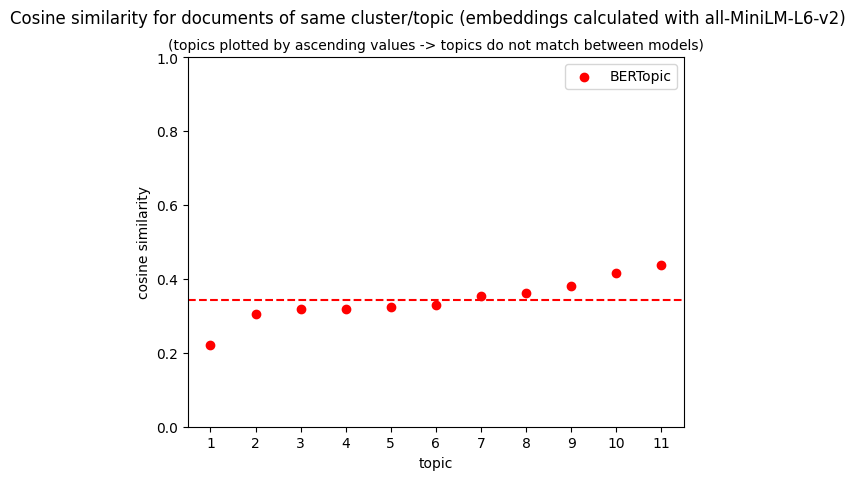

In [52]:
list1 = df_bertopic.cos_sim_intra_mean.sort_values(ascending=True)

lists_of_cv = [list1]
model_names = ["BERTopic"]
# std = [std1, std2, std3]
title = "Cosine similarity for documents of same cluster/topic (embeddings calculated with all-MiniLM-L6-v2)"
y_label = "cosine similarity"
plot_metrics(lists_of_cv, model_names, title, y_label)

In [53]:
np.mean(list1)

0.3420679798609368

# Conclusion
This work **aims to demonstrate how topic modeling algorithms can be leveraged for analyzing Twitter data**. We provide a comprehensive analysis of each algorithm, including a detailed exploration of how it operates and how it selects words for analysis. By **carefully examining the strengths and benefits of each algorithm, we seek to provide valuable insights into their potential use cases and applications**.


To achieve this, **we delve deeply into the workings of each algorithm, providing a thorough explanation of its underlying principles and techniques**. We then explore how each algorithm selects and analyzes the words in the data, including an assessment of the approaches used to identify relevant terms and phrases.


Our **analysis focuses specifically on two topic modeling algorithms, top2vec and BERTopic**. These approaches are of particular interest due to their use of word embedding, a technique that has been shown to be highly effective in comparison to traditional probabilistic models such as LDA.
As both top2vec and BERTopic leverage word embedding, we seek to compare and contrast these two approaches in order to identify their unique strengths and differences. While BERTopic is built using the same underlying architecture as top2vec, **there are important distinctions in the way that the two algorithms operate and the results that they produce**.

**By closely examining these differences and similarities, we aim to provide insights into the respective capabilities and limitations of each algorithm**.



It is important to note that **topic modeling is an unsupervised task**, meaning that there is no established ground truth to compare our results to. As a result, **evaluating the performance of a topic modeling algorithm in terms of traditional metrics can be challenging**.
Despite these difficulties, we have sought to **leverage existing metrics that have been developed and studied in the field of topic modeling**. In addition, we have also **developed a new metric to assess the inertia intra cluster**, which can provide valuable insights into the quality of the clustering produced by a topic modeling algorithm.

Furthermore, we have developed and explored new visualization tools that can help guide us through the topic discovery process and provide a visual representation of the algorithm's output. These visualization tools can be particularly helpful in assessing the quality of the algorithm's results and identifying any potential issues or areas for improvement.

Overall, **our approach seeks to address the challenges inherent in evaluating the performance of unsupervised topic modeling algorithms by leveraging both existing metrics and developing new tools and techniques**. Through these efforts, we aim to provide a more comprehensive and nuanced understanding of the capabilities and limitations of these algorithms, and to facilitate the development of more effective and efficient data analysis techniques for this important domain.


**Some considerations**



- In our analysis, we found that both **top2vec and BERTopic outperformed traditional probabilistic model LDA across all metrics studied**. In addition, we manually inspected the choice of words selected by these algorithms and found that they performed better than LDA in this regard as well.

$\;\;\;\;\;\;\;\;$ 

- While both **top2vec and BERTopic produced strong results**, we also observed important differences between the two approaches. Specifically, **BERTopic demonstrated greater topic diversity**, meaning that it was capable of identifying a wider range of distinct topics. Our analysis found that **BERTopic outperformed top2vec in terms of PMI score, indicating that it had a stronger ability to choose words that were highly relevant to each topic**. 

$\;\;\;\;\;\;\;\;$ 

- **BERTopic's approach** of selecting words based on c-tf-idf values is **more suitable for analyzing social media posts** such as Twitter. **This is because people often associate words based on the trends of the moment, and not necessarily on their semantic similarity**. For example, during the COVID-19 pandemic, many people associated the word "supermarket" with "panic" because they were afraid that food would run out and this would cause panic among people. In normal situations, "supermarket" and "panic" would not occur together frequently, so their cosine similarity would be low. **BERTopic's approach**, on the other hand, **is more realistic and can capture such associations between words that are not necessarily similar in general**. Therefore, BERTopic is better suited for identifying topics that are more relevant to the context of social media posts.

$\;\;\;\;\;\;\;\;$

While our analysis found that BERTopic and top2vec outperformed LDA in several metrics and that BERTopic had some advantages over top2vec in certain areas, **it's important to note that the choice of topic modeling algorithm depends on the specific goals and requirements of the analysis**.

Different algorithms have different strengths and weaknesses, and the choice of algorithm will depend on factors such as the size and complexity of the dataset and  the specific research questions being addressed.

Ultimately, the choice of topic modeling algorithm should be driven by the specific needs and goals of the analysis, rather than a one-size-fits-all approach.